# Multivariate Analysis

## Objective

This notebook is showcasing of __multivariate exploratory data analysis__ to:
- Understand joint behaviour of multiple features
- Detect redundancy and multicollinearity
- Identify latent structure and segments
- Surface compound bias and proxy effects

Multivariate analysis answers:

    "What patterns only emerge when features act together?"
## Why multivariate EDA matters
Skipping multivariate EDA leads to:
- Inflated variance in linear models
- Redundant feature engineering
- Hidden proxy discrimination
- Unstable feature importance

This notebook ensures __Structural awareness before modelling.__

## Imports and Configuration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1 - Load Dataset

We reuse the dataset from previews EDA notebooks for contituity.

In [50]:
np.random.seed(2010)

N = 5000

df = pd.DataFrame({
    "age": np.random.randint(18, 75, size=N),
    "income": np.random.lognormal(mean=10.8, sigma=0.5, size=N),
    "tenure_years": np.random.exponential(scale=6, size=N),
    "transactions_last_30d": np.random.poisson(lam=4, size=N),
    "region": np.random.choice(
        ["North", "South", "East", "West"],
        size=N,
        p=[0.35, 0.25, 0.25, 0.15]
    ),
    "churn": np.random.binomial(1, 0.28, size=N)
})

df.head()

,age,income,tenure_years,transactions_last_30d,region,churn
0,18,46379.336001,5.749047,4,North,0
1,18,69314.800389,1.537824,5,South,0
2,67,72641.701777,24.502748,3,North,0
3,64,54855.223706,1.502888,3,South,0
4,37,28564.604800,3.950600,6,North,0


# Step 2 - Multicollinearity Diagnostics
## Correlation Structure

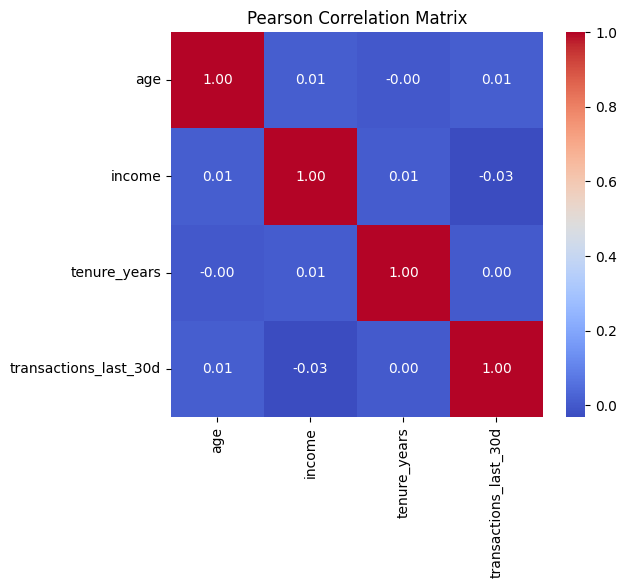

In [26]:
numeric_cols = [
    "age",
    "income",
    "tenure_years",
    "transactions_last_30d"
]

corr_matrix = df[numeric_cols].corr(method="pearson")

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Pearson Correlation Matrix")
plt.show()


### Interpretation
- No severe multicollinearity
- Linear models should remain stable

## Variance Inflation Factor (Conceptual)
Although VIF is model-dependent, rule of thumb:

| VIF  | Risk      |
| ---- | --------- |
| < 5  | Safe      |
| 5–10 | Watch     |
| >10  | Redundant |



Low correlations suggest acceptable VIFs.


# Step 3 – Pairwise Joint Distributions

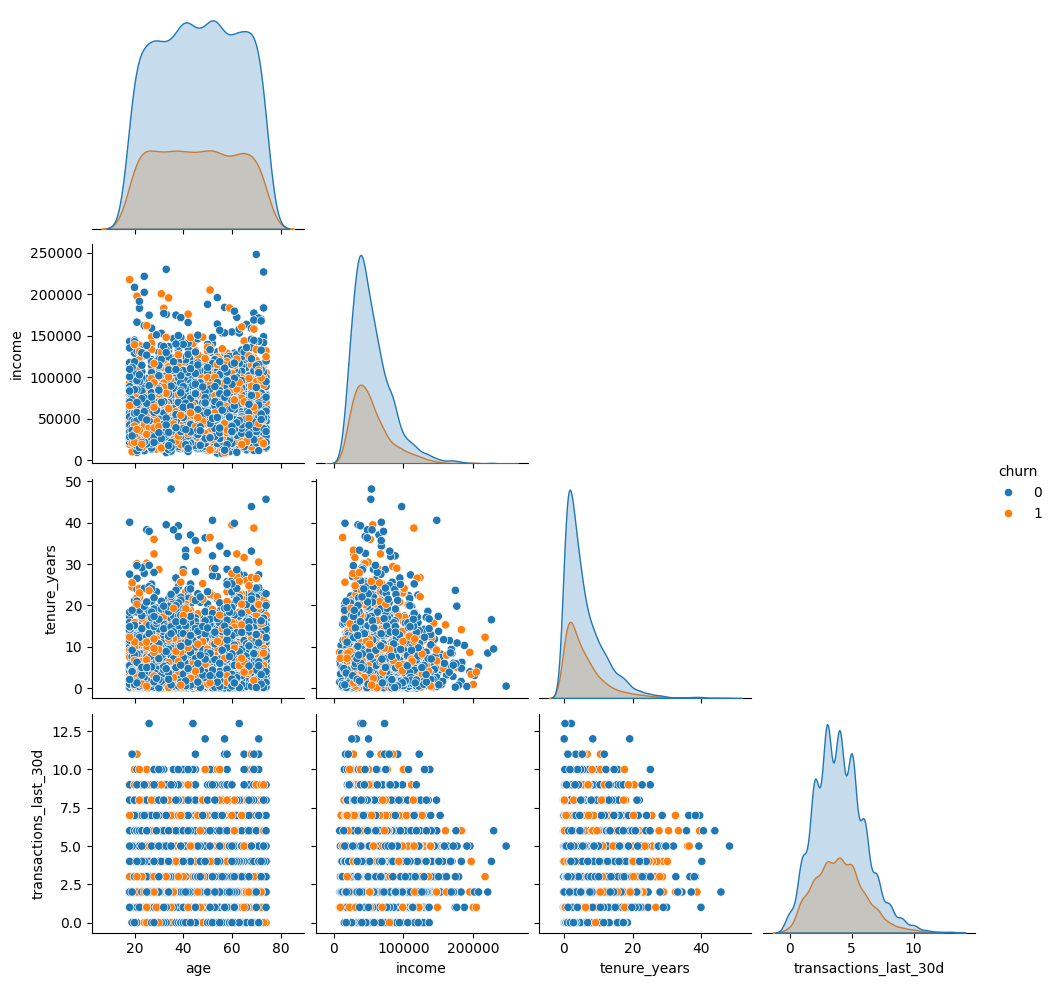

In [27]:
sns.pairplot(df[numeric_cols + ['churn']],
             hue='churn',
             diag_kind='kde',
             corner=True
            )
plt.show()

### Insight
- There are not a clear jointly features that separate churn
- Income has nonlinear effects
- No single feature dominates

# Step 4 -  Dimensionality  Reduction (PCA)
## Standardization

In [28]:
X_scaled = StandardScaler().fit_transform(df[numeric_cols])

## PCA fit

In [29]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

In [42]:
explained_variance.round(2) * 100

array([26., 25., 25., 24.])

## Explained variance

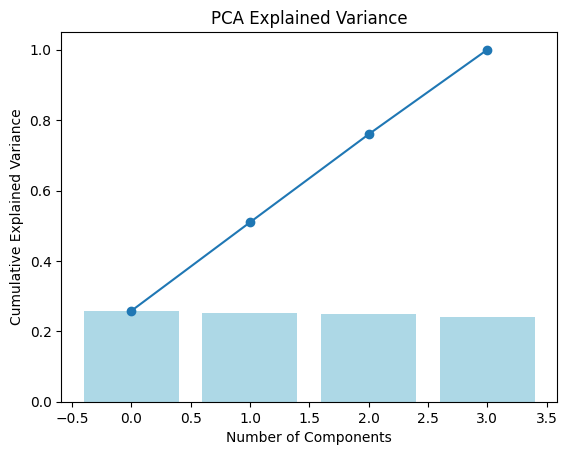

In [36]:
plt.figure()
plt.plot(
    np.cumsum(explained_variance),
    marker="o"
)
plt.bar(range(len((explained_variance))), explained_variance, color='lightblue')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


### Interpretation

- Usually, 2–3 components explain most variance. In this case we need all component( and their distribution are as follow (in %): [26, 25, 25, 24]


- Feature space is compact

# Step 6 – Proxy and Bias Risk Analysis
## Region × Income × Churn

In [47]:
region_income_churn = df.groupby('region')[['income', 'churn']].mean()
round(region_income_churn, 2)

,income,churn
region,,
East,54830.14,0.29
North,54267.16,0.27
South,56091.18,0.29
West,54470.76,0.27


### Risk Assessment

- Average income is very similar across regions
    - All regions fall in a narrow band (~$54k–$56k).


- Churn rates are also very similar
    - Churn ranges only from 27% to 29%.


- Regions with slightly higher income do not have lower churn
    - South has the highest income but also higher churn (0.29)
    - North and West have lower churn (0.27) despite slightly lower income
    
_`Average income and churn rates are broadly consistent across regions, suggesting that regional income differences are not a key driver of churn.`_

# Step 7  ANOVA test (region → churn)

This checks whether mean churn differs by region.

In [48]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_model = ols("churn ~ C(region)", data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                sum_sq      df         F    PR(>F)
C(region)     0.402005     3.0  0.661833  0.575463
Residual   1011.541795  4996.0       NaN       NaN


## Insight
- PR(>F) for C(region):


    > 0.05 → no statistically significant difference in churn across regions, which is our case (PR(>F)

    ≤ 0.05 → at least one region differs

# Step 8 – Feature Interaction Candidates

Strong candidates identified:

- tenure_years × transactions_last_30d

- log(income) × tenure_years

- region × income bucket

To be engineered in:

    03_Feature_Engineering/

# Step 8 – Multivariate EDA Deliverables

This notebook outputs:

- Redundancy assessment

- Latent structure (PCA)

- Interaction hypotheses

- Bias and proxy risks

This informs:

- Model choice (linear vs nonlinear)

- Feature engineering priorities

- Fairness evaluation scope

## Summary

This notebook demonstrated:

- Multicollinearity analysis

- Joint distribution diagnostics

- PCA for structure discovery

- Multivariate segmentation

- Bias propagation risks

__Multivariate EDA prevents silent model failure.__